https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3

In [22]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [23]:

#data = np.load('data_codingset_ash.npz',allow_pickle = True)
data = np.load('data_codingset_pollen.npz',allow_pickle = True)



#print(data['label'])

metadata_ash = np.array(data['metadata_pollen'])
data_ash = np.array(data['data_pollen'])
label = np.array(data['label'])[0]


#data_pollen = np.array( data2['data_pollen'][:100] )






print(data_ash.shape)
print(metadata_ash.shape)

#print(data_pollen.shape)



(18000, 64, 64)
(18000, 39)


In [24]:
train_images, rest_images, train_label, rest_label = train_test_split(data_ash, label, test_size=0.4, random_state=13052020)
val_images, test_images, val_labels, test_labels = train_test_split(rest_images, rest_label, test_size=0.3, random_state=13052020)


meta_train_images, meta_rest_images, meta_train_label, meta_rest_label = train_test_split(metadata_ash, label, test_size=0.4, random_state=13052020)
meta_val_images, meta_test_images, meta_val_labels, meta_test_labels = train_test_split(meta_rest_images, meta_rest_label, test_size=0.3, random_state=13052020)



# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)



# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

meta_mu = np.mean(meta_train_images)
meta_sigma = np.std(meta_train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

meta_train_images = standardizeimg(img=meta_train_images, mu=meta_mu, sigma=meta_sigma)
meta_val_images = standardizeimg(img=meta_val_images, mu=np.mean(meta_val_images), sigma=np.std(meta_val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3
train_labels = tensorflow.keras.utils.to_categorical(train_label, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
meta_test_images = standardizeimg(meta_test_images,mu = meta_mu , sigma = meta_sigma)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

#data_pollen = standardizeimg(img=data_pollen, mu=mu_train, sigma=sigma_train)
#data_pollen = data_pollen.reshape(data_pollen.shape[0], img_rows, img_cols, 1)


In [25]:
meta_test_images.shape

(2160, 39)

In [26]:
print(sigma_train)

38.88360445731909


In [27]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (10800, 64, 64, 1)
 > labels: (10800, 3)
Validation set:
 > images: (5040, 64, 64, 1)
 > labels: (5040, 3)
Test set:
 > images: (2160, 64, 64, 1)
 > labels: (2160, 3)


# Verify first 5 mages in each split dataset

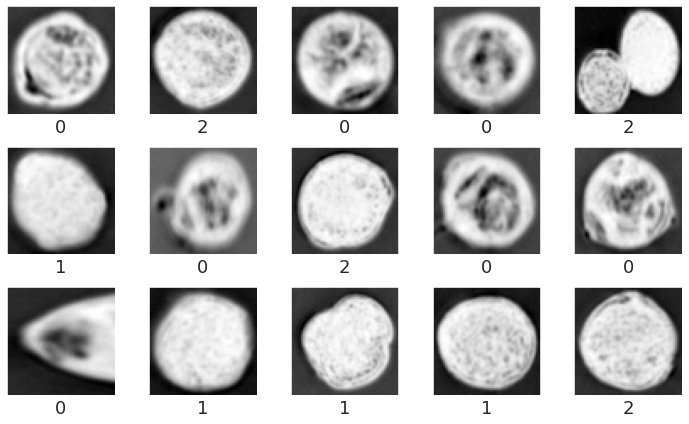

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))

N = 64

for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

# Check for (un)balanced data

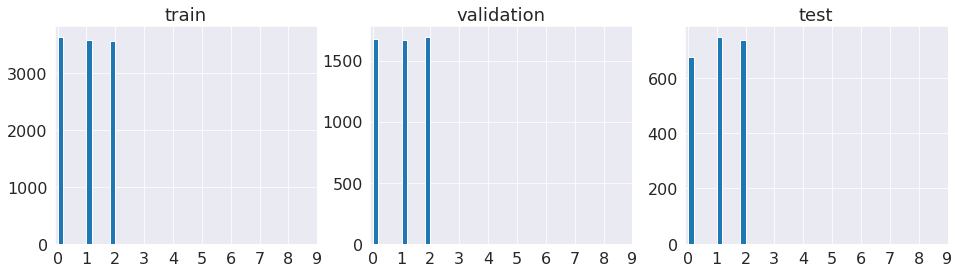

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(10)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(10)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(10)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

# Create architecture

In [30]:
input_img = Input(shape = (img_rows, img_cols, 1))
input_meta = Input(shape = (39,))

x = Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(input_img)
x = MaxPooling2D(pool_size=2, strides=None)(x)
x = Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=None)(x)

#Nyt start =========================================   Uden metadata var 0.68: 0.75 -> 0.77 -> 0.75 -> 0.73 -> 0.72 -> 0.75 -> 0.75
#x = Conv2D(filters=64,
#                 kernel_size=3,
#                 strides=1,
#                 padding='same',
#                 activation='relu')(x)
#x = MaxPooling2D(pool_size=2, strides=None)(x)
#x = Conv2D(filters=64,
#                 kernel_size=3,
#                 strides=1,
#                 padding='same',
#                 activation='relu')(x)
#x = MaxPooling2D(pool_size=2, strides=None)(x)
#Nyt slut ========================================== 

x = Dropout(rate=0.40)(x)

x = Flatten()(x)
x = Dense(units=128, activation='relu')(x) 
x1 = Dense(128,activation = 'sigmoid')(input_meta) #New
x = concatenate([x,x1])
x = Dense(1024,activation = 'sigmoid')(x)

output = Dense(units=num_classes, activation='softmax')(x)

model = Model(inputs = [input_img ,input_meta],outputs = output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   18496       max_pooling2d_2[0][0]            
____________________________________________________________________________________________

# Compile and train model

In [31]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit([train_images,meta_train_images], train_labels,
                    batch_size=64,
                    epochs=7,
                    verbose=1,
                    validation_data=([val_images,meta_val_images], val_labels))

Epoch 1/7
169/169 [==============================] - 15s 88ms/step - loss: 0.7537 - categorical_accuracy: 0.6255 - val_loss: 0.4362 - val_categorical_accuracy: 0.7855
Epoch 2/7
169/169 [==============================] - 14s 80ms/step - loss: 0.3951 - categorical_accuracy: 0.8175 - val_loss: 0.3604 - val_categorical_accuracy: 0.8290
Epoch 3/7
169/169 [==============================] - 14s 81ms/step - loss: 0.3570 - categorical_accuracy: 0.8370 - val_loss: 0.3495 - val_categorical_accuracy: 0.8393
Epoch 4/7
169/169 [==============================] - 14s 80ms/step - loss: 0.3339 - categorical_accuracy: 0.8426 - val_loss: 0.3398 - val_categorical_accuracy: 0.8486
Epoch 5/7
169/169 [==============================] - 14s 80ms/step - loss: 0.3025 - categorical_accuracy: 0.8606 - val_loss: 0.3978 - val_categorical_accuracy: 0.8165
Epoch 6/7
169/169 [==============================] - 14s 83ms/step - loss: 0.2962 - categorical_accuracy: 0.8666 - val_loss: 0.3153 - val_categorical_accuracy: 0.864

In [32]:
model.save('model_pollen')

In [33]:
extractor = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=model.layers[-2].output)

features_ash = extractor([train_images,meta_train_images])


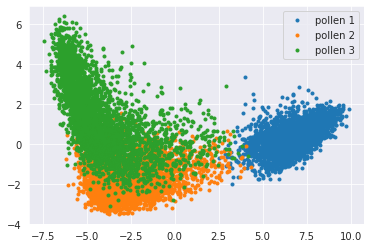

In [34]:
from sklearn.decomposition import PCA

pca = PCA(3)

pca.fit(features_ash)

pca_0 = pca.transform(  features_ash[train_label == 0]  )
pca_1 = pca.transform(  features_ash[train_label == 1]  )
pca_2 = pca.transform(  features_ash[train_label == 2]  )


plt.plot(pca_0[:,0],pca_0[:,1],'.', label = 'pollen 1')
plt.plot(pca_1[:,0],pca_1[:,1],'.', label = 'pollen 2')
plt.plot(pca_2[:,0],pca_2[:,1],'.', label = 'pollen 3')

plt.legend()

plt.show()




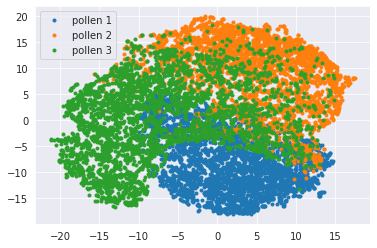

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(3)

tsne_transformed = tsne.fit_transform(features_ash)

tsne_0 = tsne_transformed[train_label == 0] 
tsne_1 = tsne_transformed[train_label == 1] 
tsne_2 = tsne_transformed[train_label == 2] 

plt.plot(tsne_0[:,0],tsne_0[:,1],'.', label = 'pollen 1')
plt.plot(tsne_1[:,0],tsne_1[:,1],'.', label = 'pollen 2')
plt.plot(tsne_2[:,0],tsne_2[:,1],'.', label = 'pollen 3')

plt.legend()

plt.show()

# Evaluate training process

158/158 - 1s - loss: 0.3021 - categorical_accuracy: 0.8667


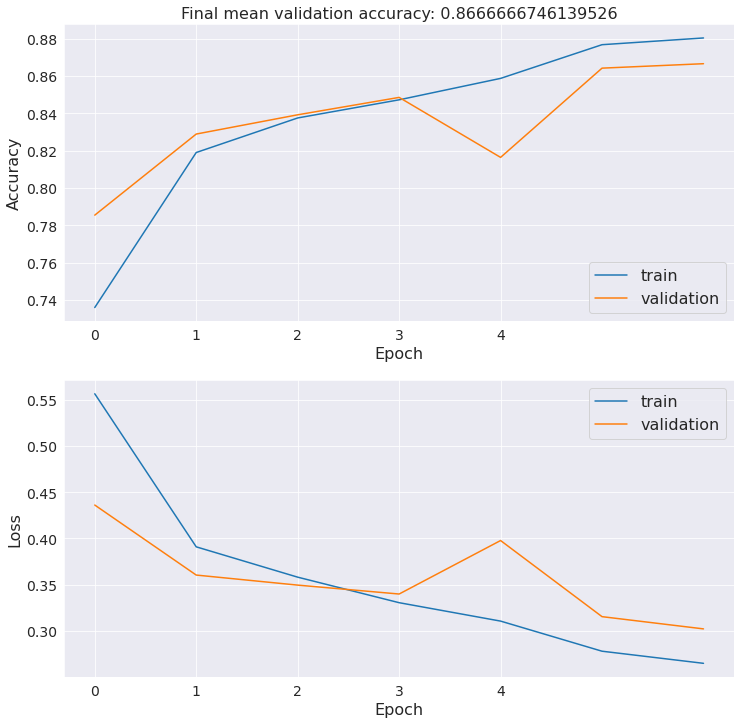

In [36]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate([val_images,meta_val_images], val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

# Inference

In [37]:
# using until now unseen data
predicted_prob = model.predict([test_images,meta_test_images])
predictions = np.argmax(predicted_prob, axis=1)

In [38]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1), predictions=predictions, num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[668   5   3]
 [ 17 631 100]
 [  6 160 570]], shape=(3, 3), dtype=int32)


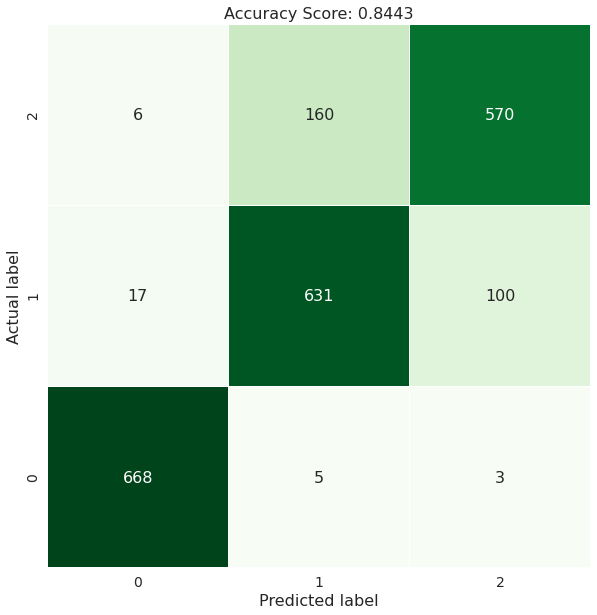

Correct: 1869/2160
Wrong: 291/2160


In [39]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

# Inspection of predictions

### Correctly predicted images

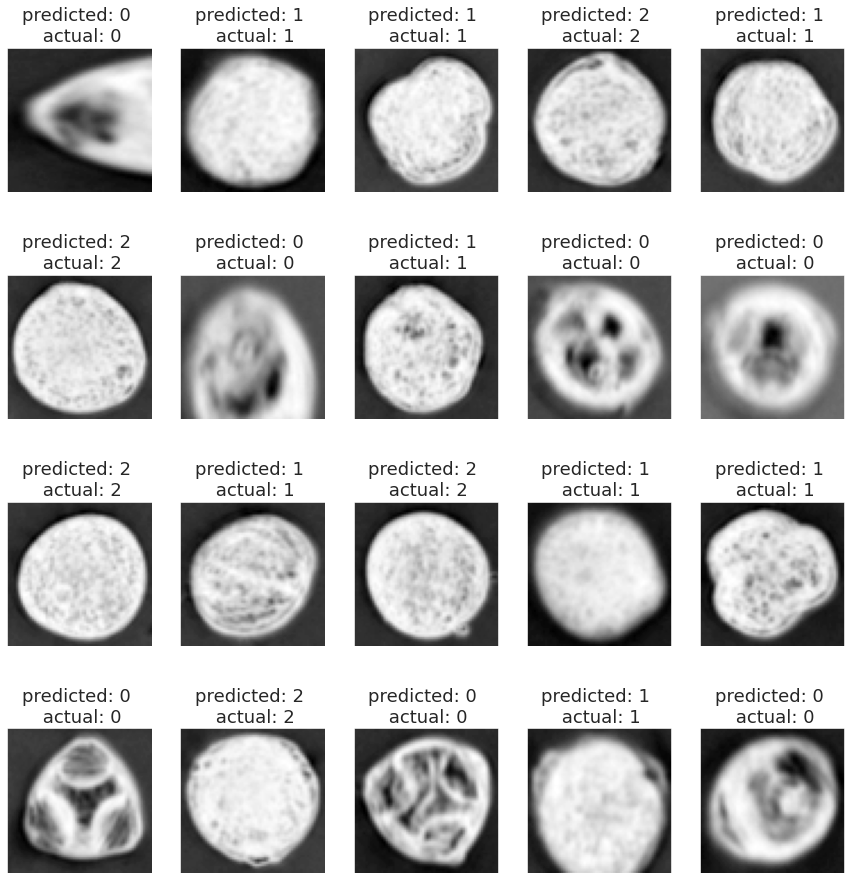

In [40]:
# show first 10 images that were correctly predicted
correct_idx = np.where(predictions == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(4,5, figsize=(15, 16))
axs = axs.ravel()
for i in range(20):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Wrongly predicted images

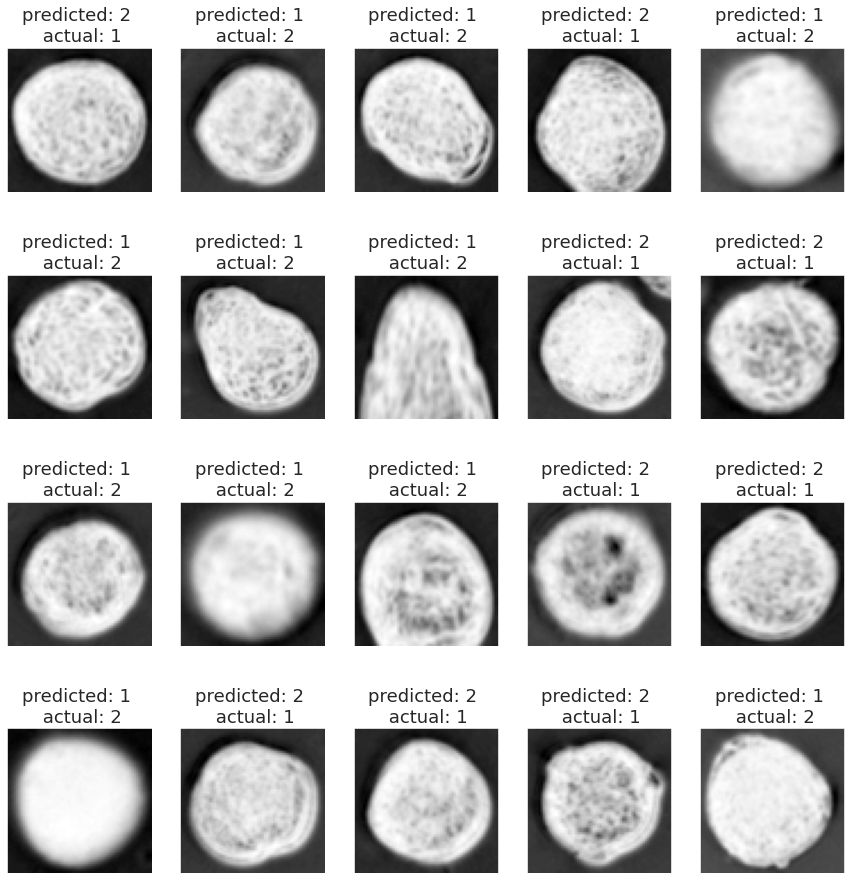

In [42]:
# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(predictions != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(4,5, figsize=(15, 16))
axs = axs.ravel()
for i in range(20):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)